# FINAL PROJECT: BOOTSTRAPPING

### Name: Carlos Cocha

#### Loading the required packages

In [1]:
import statistics
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [14]:
def average(x, sx = [], w = False):
    '''
    Function to calculate the average (weighted if w = True) of a set x.
    
    Parameters:
    x     :: set of data
    sx    :: uncertainty of the data
    
    Example:
    average([2,5,4,5,7], [0.5,0.2,0.4,0.5,0.3],  w = True)
    - 5.07887
    '''
    if w == True:
        n, d  = 0, 0
        for i in range(len(x)):
            n += x[i]/(sx[i]*sx[i])
            d += 1/(sx[i]**2)
        x_w = n/d
    else:
        x_w = np.sum(x)/len(x)
    return x_w

In [53]:
def slope_inter(x, y, w = False, ws = [] ):
    '''
    Function to calculate the intercept (y0) and the slope (m) parameters of
    y = y0 + m*x or y = y0 + m*[x-x^](if w = True)  given  2 sets of data (x, y). 
    
    Parameter:
    x :: set of data x
    y :: set of data y
    
    Example:
    slope_inter([0.5 , 0.9 , 1.5 , 1.8 , 2.65], [2.4 , 3.1 , 4.7 , 4.9 , 6.3])
    (4.279999999999999, 1.8414017341040463)
    '''
    numerator = 0
    denominator = 0
    
    if w == True:
        x_m =  average(x, sy, w = False)
        y_m = average(y, sy, w = False)

        numerator = np.sum(ws*(x-x_m)*(y-y_m))
        denominator = np.sum(ws*(x-x_m)*(x-x_m))
        m = numerator/denominator #slope
        y0 = y_m                  #interception
        
    else:
        x_m = average(x)
        y_m = average(y)
        
        numerator = np.sum((x-x_m)*(y-y_m))
        denominator = np.sum((x-x_m)*(x-x_m))
        m = numerator/denominator  #slope
        y0 = y_m - m*x_m           #interception
    
    return y0 , m

In [37]:
def cov(array1, array2):
    '''
    Function to calculate de covariance of 2 datasets.
    
    Parameters:
    array1 :: set of data1
    array2 :: set of data2
    
    Example:
    cov([1, 2, 4, 6, 3], [3, 5, 3, 2, 7])
    -1.5    
    '''
    n = 0
    M = len(array1)
    a1_m = np.array(array1).mean()
    a2_m = np.array(array2).mean()
    for i in range(M):
        n += (array1[i] - a1_m)*(array2[i] - a2_m)
    covariance = n/(M-1)
    return covariance

In [38]:
def stand_d(x):
    '''
    Function to calculate the standard deviation of a set x.
    
    Parameters:
    x :: set of data
    
    Example:
    stand_d([2,5,2,4,5,7,3])
    - 1.82574
    '''
    x_m = np.mean(x)
    n = 0
    for i in range(len(x)):
        n += (x[i] - x_m)**2
    sd = np.sqrt(n/(len(x) - 1))
    return sd

In [49]:
def pearson(x, y, w = False, ws = []):
    '''
    Function to calculate the Pearson’s r coefficient given x and y data.
    
    Parameters:
    x :: set of data
    y :: set of data
    ws = weights 
    
    Example:
    pearson(x, y, w = True, ws = 1/sy**2)
    0.99463
    '''
    if w == True:
        n = np.sum(ws)*np.sum(ws*x*y)-np.sum(ws*x)*np.sum(ws*y)
        d = np.sqrt(np.sum(ws)*np.sum(ws*x*x)-(np.sum(ws*x))**2)*np.sqrt(np.sum(ws)*np.sum(ws*y*y)-(np.sum(ws*y))**2)
        r = n/d
    else:
        sx = np.sqrt(np.sum((x-average(x))**2)/(len(x)-1))
        sy = np.sqrt(np.sum((y-average(y))**2)/(len(y)-1))
        n = cov(x, y)
        d = sx*sy
        r = n/d
    return r    

In [130]:
def plot_histo(data_tm, xlabel, ax=None, **plt_kwargs):
    '''Function to plot the histograms with  their main properties'''

    ax.hist(data_tm, bins=50, range=[min(data_tm), max(data_tm)], fc='none',
            histtype='step', color='black', label= xlabel+' = '+str(round(data_tm.mean(),4))+
            ' $\pm$ ' +str(round( np.std(data_tm),4)), linewidth=.8)
    ax.legend(loc='lower right')
    ax.set_xlabel(xlabel, size= 10 )
    ax.set_ylabel('amplitude', size= 10)
    return ax

### 1. Read the data: x𝑖 ± 𝜎x𝑖, y𝑖 ± 𝜎y𝑖

In [2]:
# Reading the data from a .csv file
data = pd.read_csv("DATA.csv")
headers = ['x','y','sigma_x','sigma_y']
dframe = pd.DataFrame(data.values, columns = headers)
dframe

,x,y,sigma_x,sigma_y
0,0.50,2.40,0.02,0.6
1,0.90,3.10,0.09,1.8
2,1.50,4.70,0.15,1.5
3,1.80,4.90,0.18,0.6
4,2.65,6.30,0.45,3.0
5,3.00,8.05,0.05,0.2
6,3.45,8.80,0.07,0.4
7,4.10,11.50,0.25,3.2
8,4.65,11.20,0.15,0.8
9,5.25,14.30,0.25,2.4


In [3]:
# Copying the data into variables 
x = dframe['x']
y = dframe['y']
sx = dframe['sigma_x']
sy = dframe['sigma_y']

### 2. Obtain up to M = 1000 sets of datapoints {{𝑥𝑖, 𝑦𝑖} k} 𝑖  = 1, …, 𝑁,  𝑘 = 1, …, 𝑀 by resampling from your experimental data. Use the generator producing random numbers with Gaussian distribution

In [50]:
M = 1000
resampling = [] # to save all the resampling data
for i in range(M):
    x_d , y_d = [] , []
    for j in range(len(x)):
        # random.randn produce random numbers with Gaussian distribution
        x_d.append(x[j] + sx[j]*np.random.randn())
        y_d.append(y[j] + sy[j]*np.random.randn())
    resampling.append([x_d, y_d])

### 3. For each artificially resampled dataset, calculate their own slope and intercept (do NOT calculate their errors here!).

In [55]:
y0_m_dat = np.zeros((M, 2))  
y0_mw_dat = np.zeros((M, 2)) # to save the weighted fitting parameters
for i in range(M):
    # Calculate the slope and interception of each resampling dataset.
    y0_m_dat[i][0], y0_m_dat[i][1] = slope_inter(resampling[i][0], resampling[i][1])
    # For the weighted fitting w = True
    y0_mw_dat[i][0], y0_mw_dat[i][1] = slope_inter(resampling[i][0], resampling[i][1],  w = True, ws = 1/(sy**2))

### 4. Once the loop is finished, provide as output: y0 ± 𝜎y0 and m ± 𝜎m using the mean and standard deviation of the y0𝑘, m𝑘𝑘 = 1𝑀 values obtained.

In [75]:
# Results fot the unweighted fitting
y0_m = y0_m_dat[:, 0].mean()
m_m = y0_m_dat[:, 1].mean()
sd_y0 = stand_d(y0_m_dat[:, 0])
sd_m = stand_d(y0_m_dat[:, 1])
print('The results using y = y0 + m*x fitting are:')
print('y0 ± 𝜎y0 = ' + str(round(y0_m, 4)) +  " ± " + str(round(sd_y0, 4)))
print('m  ± 𝜎m  = ' + str(round(m_m, 4)) +  " ± " + str(round(sd_m, 4)))
cov_y0_m = cov(y0_m_dat[:, 0], y0_m_dat[:, 1])
print("cov(y0, m) =", str(round(cov_y0_m,2)))

The results using y = y0 + m*x fitting are:
y0 ± 𝜎y0 = 0.8561 ± 0.9417
m  ± 𝜎m  = 2.3895 ± 0.3782
cov(y0, m) = -0.29


In [74]:
# Results fot the weighted fitting
y0_mw = y0_mw_dat[:, 0].mean()
m_mw = y0_mw_dat[:, 1].mean()
sd_y0w = stand_d(y0_mw_dat[:, 0])
sd_mw = stand_d(y0_mw_dat[:, 1])
print('The results using y = y0 + m*(x - x0) fitting are:')
print('y0 ± 𝜎y0 = ' + str(round(y0_mw, 4)) +  " ± " + str(round(sd_y0w, 4)))
print('m  ± 𝜎m  = ' + str(round(m_mw, 4)) +  " ± " + str(round(sd_mw, 4)))
cov_y0_mw = cov(y0_mw_dat[:, 0], y0_mw_dat[:, 1])
print("cov(y0, m) =", str(round(cov_y0_mw,2)))

The results using y = y0 + m*(x - x0) fitting are:
y0 ± 𝜎y0 = 7.5052 ± 0.5838
m  ± 𝜎m  = 2.2055 ± 0.2035
cov(y0, m) = -0.03


#### Contour plot between m and y0:

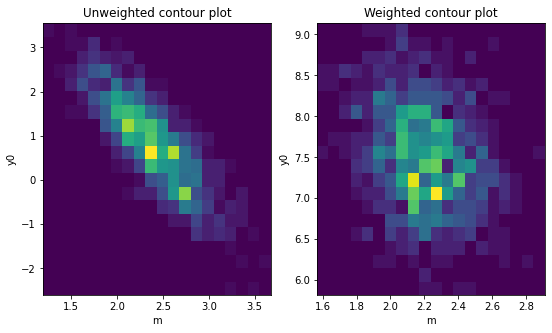

In [88]:
fig = plt.figure(figsize=(9,5))
gs = GridSpec(1,2) # 1 rows, 2 columns
ax1 = fig.add_subplot(gs[0,0])
ax1.hist2d(y0_m_dat[:, 1], y0_m_dat[:, 0], bins = 20)
ax2 = fig.add_subplot(gs[0,1])
ax2.hist2d(y0_mw_dat[:, 1], y0_mw_dat[:, 0], bins = 20)
ax1.set_title('Unweighted contour plot')
ax2.set_title('Weighted contour plot')
ax1.set_xlabel("m")
ax1.set_ylabel('y0')
ax2.set_xlabel("m")
ax2.set_ylabel('y0')
plt.show()

By definition, covariance measures the total variation of two random variables from their expected values. A covariance equal to 0 means that the two variables are independent each other (no linear tendency), as is observed in the weighted contour plot. But, for the unweighted contour plot a linear dependence is observed.Which make sense because y0 and m are least-squares regression parameters (y0 = 𝑦 − m*𝑥), that define the straight line that maximizes the amount of variation in y that can be explained by a linear regression on x. So, y0 and m are not independent of each other.

Also, using the covariance value allow us to estimate the direction of the relationship (whether the variables tend to move in tandem). According to the calculations the cov(y0, m) < 0 which means that y0 and m coefficientes tend to move in the opposite directions (increase in y0 corresponds a decrease in m).

### 1D frequency histograms of {y0_𝑘}𝑘 = 1, ..., 𝑀 and {m_𝑘} 𝑘 = 1, ..., 𝑀.

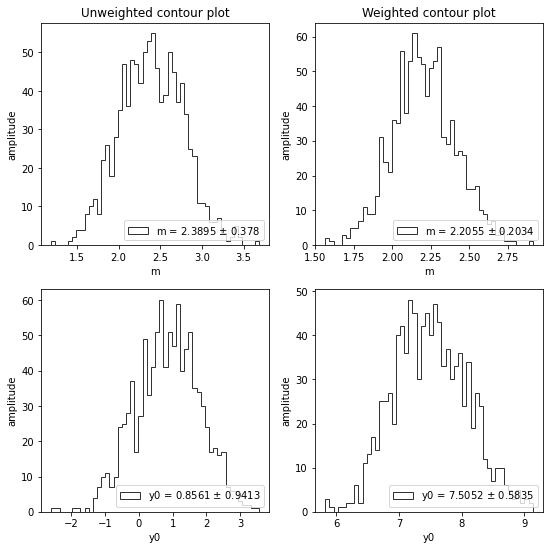

In [129]:
fig = plt.figure(figsize=(9,9))
gs = GridSpec(2,2) # 1 rows, 2 columns
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
plot_histo(y0_m_dat[:, 1],"m", ax1)
plot_histo(y0_mw_dat[:, 1],"m", ax2)
plot_histo(y0_m_dat[:, 0],"y0", ax3)
plot_histo(y0_mw_dat[:, 0],"y0", ax4)
ax1.set_title('Unweighted contour plot')
ax2.set_title('Weighted contour plot')
plt.show()